**Introduction**

Below codes come from an excellent article from [R2RT](https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html), with detailed explanation in HOWs and WHYs in RNN implementation with TensorFlow 1.0. I learnt a lot from this article and hopefully you can as well.

The most important thing to remember here is RNN introduces the concept of "time steps" which inherently requires specific requirements for inputs format. This is the central theme which governs the whole implementation.

Below is the RNN architecture used:

![RNN architecture](https://r2rt.com/static/images/BasicRNNLabeled.png)


EPOCH 0
Average loss at step 100 for last 250 steps: 0.634926326275
Average loss at step 200 for last 250 steps: 0.564726597667
Average loss at step 300 for last 250 steps: 0.561335769892
Average loss at step 400 for last 250 steps: 0.559246102571
Average loss at step 500 for last 250 steps: 0.554829942584
Average loss at step 600 for last 250 steps: 0.527248063684
Average loss at step 700 for last 250 steps: 0.520829907358
Average loss at step 800 for last 250 steps: 0.520399137735
Average loss at step 900 for last 250 steps: 0.520683761835


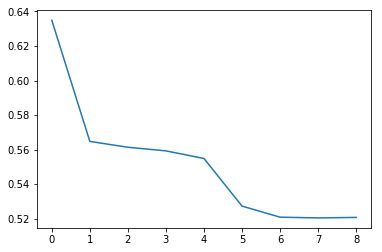

In [1]:
# basic implementation

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Global configuration variables or hyperparameters
num_steps = 5 # number of truncated backprop steps
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    # X is a row vector with a length of 'size' with elements either 0 or 1
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)
    
    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i : batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i : batch_partition_length * (i + 1)]
        
    # further divide each batch partition into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps
    for i in range(epoch_size):
        x = data_x[:, i * num_steps : (i + 1) * num_steps]
        y = data_y[:, i * num_steps : (i + 1) * num_steps]
        yield(x, y)
        
def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)
        
# placeholders
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='inputs')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels')
init_state = tf.zeros([batch_size, state_size])

# turn our x placeholder into inputs a list of one-hot encoded tensors
# with length of num_steps, and shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

"""
Here I just want to give a visual on the above two lines to see what was going on
In [1]:
x = np.array([[1, 0, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1]]) # batch_size=3, num_steps=4
x_one_hot = tf.one_hot(x, 2) #num_classes=2
with tf.Session() as sess:
    print(sess.run(x_one_hot)) #x_one_hot.shape=(3, 4, 2)

Out [1]:
[[[ 0.  1.]
  [ 1.  0.]
  [ 1.  0.]
  [ 0.  1.]]

 [[ 0.  1.]
  [ 1.  0.]
  [ 0.  1.]
  [ 1.  0.]]

 [[ 1.  0.]
  [ 0.  1.]
  [ 1.  0.]
  [ 0.  1.]]]
  
In [2]:
rnn_inputs = tf.unstack(x_one_hot, axis=1)
with tf.Session() as sess:
    print(sess.run(rnn_inputs)) 
# rnn_inputs is a list with a length equal to the number of time steps,
# and each element is a Rank 2 tensor in the shape of (3, 2)

Out [2]:
[array([[ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.]], dtype=float32), array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]], dtype=float32), array([[ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.]], dtype=float32), array([[ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.]], dtype=float32)]

In [3]:
len(rnn_inputs)

Out [3]:
4
"""

with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    
def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
        return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)
    
"""
Adding rnn_cell to graph
"""

state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    # here we build a rnn with rnn_cell copied by num_steps times
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

"""
Predictions, loss, training step
"""

# logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

# losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x: X, y: Y, init_state: training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss /100)
                    training_losses.append(training_loss / 100)
                    training_loss = 0

    return training_losses

training_losses = train_network(1,num_steps)
plt.plot(training_losses)


EPOCH 0
Average loss at step 100 for last 250 steps: 0.628054853082
Average loss at step 200 for last 250 steps: 0.536067923307
Average loss at step 300 for last 250 steps: 0.523046225905
Average loss at step 400 for last 250 steps: 0.52222602427
Average loss at step 500 for last 250 steps: 0.518991369605
Average loss at step 600 for last 250 steps: 0.521843917966
Average loss at step 700 for last 250 steps: 0.520809316337
Average loss at step 800 for last 250 steps: 0.52087038964
Average loss at step 900 for last 250 steps: 0.522309147418


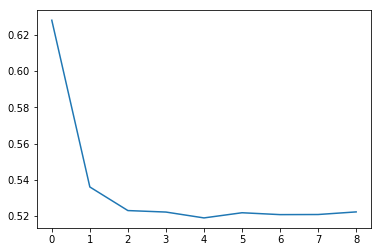

In [1]:
# Improved version with TensorFlow's dynamic_rnn API

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Global configuration variables or hyperparameters
num_steps = 5 # number of truncated backprop steps
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    # X is a row vector with a length of 'size' with elements either 0 or 1
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)
    
    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i : batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i : batch_partition_length * (i + 1)]
        
    # further divide each batch partition into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps
    for i in range(epoch_size):
        x = data_x[:, i * num_steps : (i + 1) * num_steps]
        y = data_y[:, i * num_steps : (i + 1) * num_steps]
        yield(x, y)
        
def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)
        
# placeholders
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='inputs')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels')
init_state = tf.zeros([batch_size, state_size])

# turn our x placeholder into inputs with the shape of (batch_size, num_steps, num_classes)
rnn_inputs = tf.one_hot(x, num_classes)

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

# these two lines above replace a whole bunch of codes quoted below from the previous implementation
# one common thing to notice with these API is you do not need to define paramaters anymore

"""
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    
def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
        return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    # here we build a rnn with rnn_cell copied by num_steps times
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]
"""

"""
Predictions, loss, training step
"""

# logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = tf.reshape(tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b, [batch_size, num_steps, num_classes])
predictions = tf.nn.softmax(logits)


# losses and train_step
# here y can be feeded altogether
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses

training_losses = train_network(1,num_steps)
plt.plot(training_losses)